# FastAI
Using FastAI

In [ ]:
%cd /content/
!rm -rf /content/Whats-this-rock/
# !git clone https://github.com/udaylunawat/Whats-this-rock.git
!git clone -b nbdev https://github.com/udaylunawat/Whats-this-rock.git

/content
Cloning into 'Whats-this-rock'...
remote: Enumerating objects: 3184, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 3184 (delta 19), reused 30 (delta 16), pack-reused 3143
Receiving objects: 100% (3184/3184), 10.95 MiB | 11.74 MiB/s, done.
Resolving deltas: 100% (2023/2023), done.


In [ ]:
%cd /content/Whats-this-rock/

/content/Whats-this-rock


In [ ]:
!nvidia-smi

Sat Nov  5 13:40:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git pull

Already up to date.


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import shutil

## Downloading data and moving bad, corrupted and duplicate images
### Downloading data

In [ ]:
!sh src/scripts/setup.sh

libcudnn8 is already the newest version (8.1.1.33-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Whats-this-rock (from -r requirements-dev.txt (line 1))
  Attempting uninstall: rocks-telegram-bot
    Found existing installation: rocks-telegram-bot 0.0.1
    Can't uninstall 'rocks-telegram-bot'. No files were found to uninstall.
  Running setup.py develop for rocks-telegram-bot
rock-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
renamed 'data/1_extracted/Dataset' -> 'data/1_extracted/dataset1'
igneous-metamorphic-sedimentary-rocks-and-minerals.zip: Skipping, found more recently modified local copy (use --force to force download)
Function 'download_d

## Remove duplicate images

Found duplicates using Gemini 2 (MacOS)

- scanned 1_extracted dataset 1 & dataset 2
- save duplicate & bad images in a text file

In [ ]:
from src.data.utils import move_bad_files
move_bad_files("configs/bad_images selected by gemini.txt", "data/bad_images", "Moving bad images...")
move_bad_files("configs/misclassified selected by gemini.txt", "data/misclassified_images", "Moving misclassified images...")
move_bad_files("configs/duplicates selected by gemini.txt", "data/duplicate_images", "Moving duplicate images...")

### TODO:- view bad and duplicate images in a grid

## Loading data

In [ ]:
from fastai.vision.all import *

In [ ]:
dls = ImageDataLoaders.from_folder(path='data/2_processed/', valid_pct=0.25,
                                   item_tfms=Resize(224))
dls.valid_ds.items[:3]

[Path('data/2_processed/Sandstone/dataset1_Sandstone_040_133.jpg'),
 Path('data/2_processed/Quartzite/dataset1_Quartzite_050_images(126).jpg'),
 Path('data/2_processed/Quartzite/dataset1_Quartzite_442_images(85).jpg')]

In [ ]:
print(f'Training set samples:- {len(dls.train_ds)} images.\nValidation set samples:- {len(dls.valid_ds)} images.')

Training set samples:- 1761 images.
Validation set samples:- 587 images.


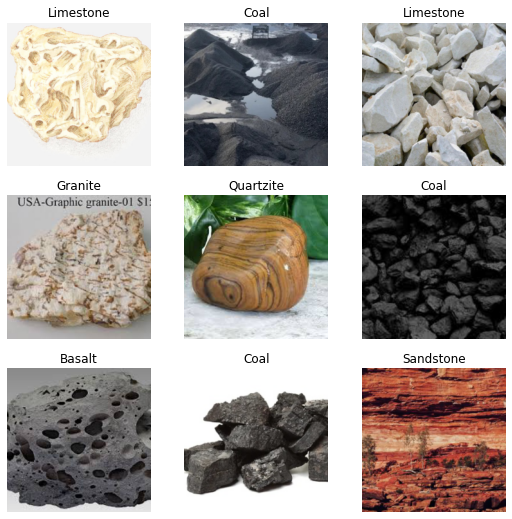

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, F1Score(average='macro')])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


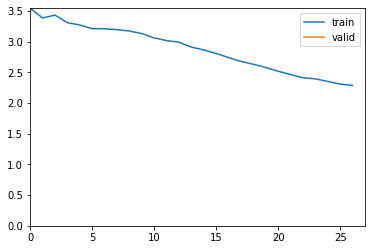

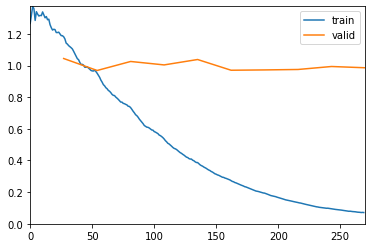

('Sandstone',
 TensorBase(6),
 TensorBase([1.7528e-05, 2.7937e-05, 6.5986e-05, 1.1654e-06, 1.4603e-04,
             4.7336e-06, 9.9974e-01]))

In [ ]:
learn.fine_tune(10, cbs=ShowGraphCallback())
learn.predict(dls.valid_ds.items[0])


Sample Results:


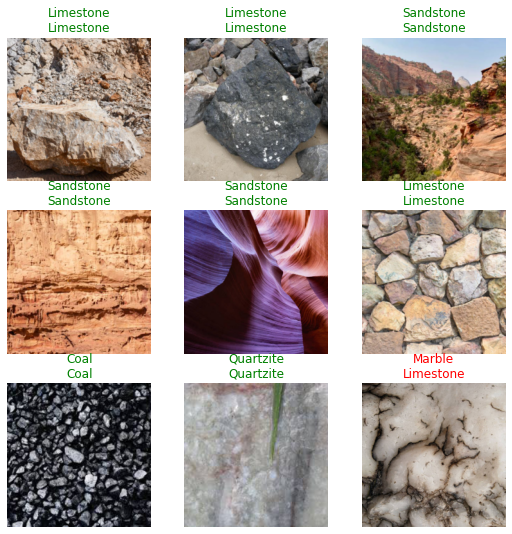


Top losses:-


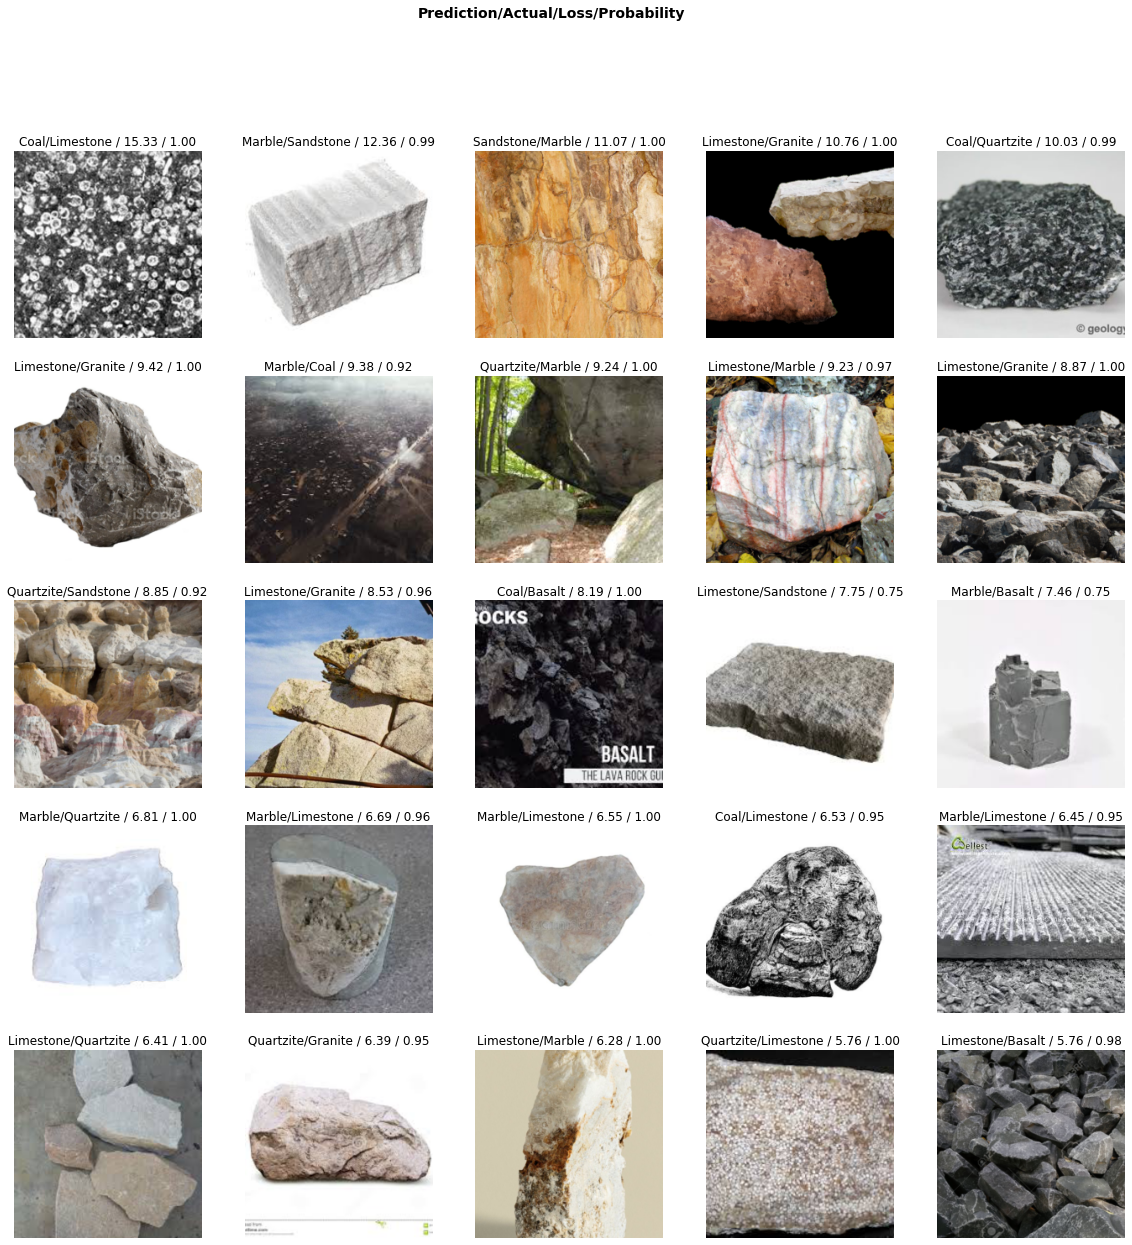


Confusion Matrix:-


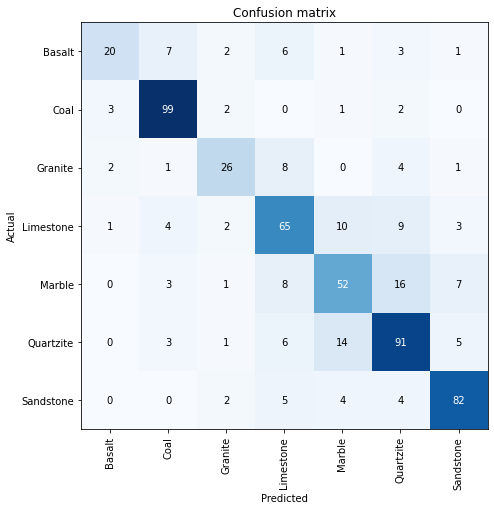


Normalized Confusion Matrix:-


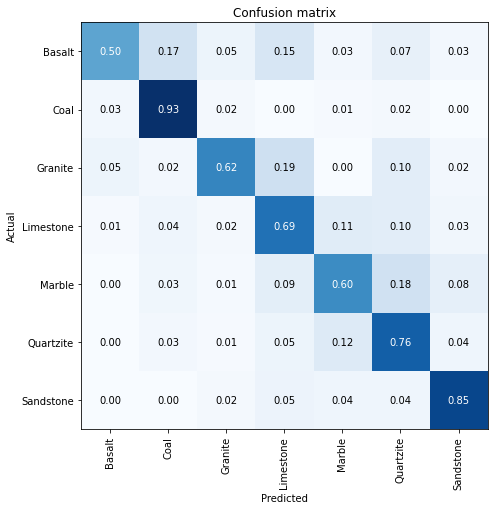

In [ ]:
def get_results(learn):
    print(f'\nSample Results:')
    learn.show_results()
    plt.show()

    interp = Interpretation.from_learner(learn)
    print(f'\nTop losses:-')
    interp.plot_top_losses(25, figsize=(20,20))
    plt.show()

    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(dls.valid_ds)==len(losses)==len(idxs)

    print(f'\nConfusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7))
    plt.show()

    print(f'\nNormalized Confusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7), normalize=True)
    plt.show()
get_results(learn)

In [ ]:
# # save model
# learn.export(file='model.pkl')

# learn = load_learner('model.pkl')

## Data Cleaning

In [ ]:
# verifying that all images are readable
img_files = get_image_files('data/2_processed/')
failed = verify_images(img_files)
assert failed == []

### Remove bad images

In [ ]:
files_to_delete = set()

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): print(cleaner.fns[idx])

for idx in cleaner.delete(): files_to_delete.add(str(cleaner.fns[idx]))

data/2_processed/Basalt/dataset1_Basalt_054_500_F_123148070_rcGuQFVCzgOdSamq7U0mleROolKCbBsJ.jpg
data/2_processed/Basalt/dataset2_Basalt_101_Basalt rock126.jpg
data/2_processed/Basalt/dataset2_Basalt_148_Basalt rock41.jpg
data/2_processed/Basalt/dataset2_Basalt_175_Basalt rock92.jpg


In [ ]:
for path in sorted(files_to_delete):
    print(path)

data/2_processed/Basalt/dataset1_Basalt_057_6.jpg
data/2_processed/Basalt/dataset1_Basalt_082_piilonen09-10.jpg
data/2_processed/Basalt/dataset2_Basalt_122_Basalt rock216.jpg
data/2_processed/Basalt/dataset2_Basalt_123_Basalt rock22.jpg
data/2_processed/Basalt/dataset2_Basalt_141_Basalt rock36.jpg


In [ ]:
def tfds_to_processed(filepath):
    base = '/'.join(str(filepath).split('/')[-2:]).replace('\')','')
    processed = os.path.join('data/2_processed', base)
    return Path(set(processed))

new_paths = list(map(lambda x:tfds_to_processed(x), files_to_delete))

In [ ]:
# update delfile
paths = read_list()
write_list(paths+new_paths, 'delete_file_pickle')

In [ ]:
latest_del = paths+new_paths

In [ ]:
try: 
    for idx in paths:
        idx.unlink()
except: pass

write_list(paths, filename='delfile')

## Using fastai Data Augmentation

In [ ]:
dls = ImageDataLoaders.from_folder(path='data/3_tfds_dataset/', train='train',
                                   valid='val', item_tfms=Resize(460),
                                   batch_tfms=aug_transforms(size=224))
dls.valid_ds.items[:3]

[Path('data/3_tfds_dataset/val/Marble/dataset1_Marble_377_marble2020(7).jpg'),
 Path('data/3_tfds_dataset/val/Marble/dataset2_Marble_406_marble rock27.jpg'),
 Path('data/3_tfds_dataset/val/Marble/dataset2_Marble_413_marble rock33.jpg')]

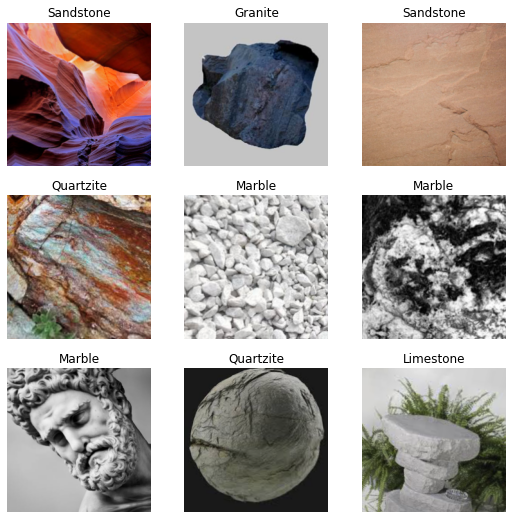

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

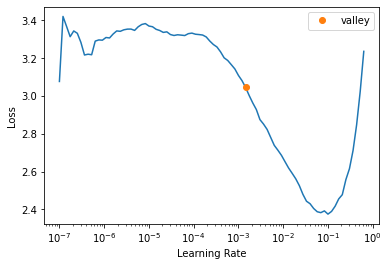

In [ ]:
learn.lr_find()

Using optimal lr

In [ ]:
learn.fine_tune(10, 3e-3)

In [ ]:
get_results(learn)